In [1]:
%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from enbed.utils.batcher import batch_provider
from enbed.utils import conv
from enbed.models import RESCAL, Energy, EnergyDiag
from enbed.training import train_RESCAL, train_energy

import numpy as np
import torch
import seaborn as sns

## Define some convenience functions for plotting later ##

In [2]:
def get_scores(model, triples):
    scores = model.prob(triples[:,0], triples[:,1], triples[:,2]).detach().numpy()
    return scores
            
def draw_plot(triples_named, labels, scores, case, ax, colors):
    labs, scs= [], []

    train_sc = []
    for i in range(len(triples_named)):
        if labels[i] == 4:
            train_sc.append(scores[i])
        else:
            labs.append(labels[i])
            scs.append(scores[i])
    labs.append(4)
    scs.append(np.mean(train_sc))
    labs = np.array(labs)
    scs = np.array(scs)

    markers = ['1', 'x', '.', '+', '*']
    x0 = 0
    totallen = 0
    for i in range(5):
        totallen += len(scs[labs==i])
    for i in range(5):
        if i in labs:
            s1 = scs[labs==i]
            xran = np.arange(x0, x0+len(s1))
            idorder = np.argsort(s1)
            marker = markers[i]
            msize = 7
            color = colors[i]
            ax.plot(xran, s1[idorder], marker = marker, markersize=msize, linewidth=0, color = color)
            x0 += len(s1)+0.065*totallen
    ax.set_ylim(0.,1.05)
    sns.despine(ax = ax)
    ax.set_xticks([])
    paneltitles = {
        'variables_access': 'Variable access',
        'ssh': 'SSH access',
        'https': 'HTTPS access',
        'scan': 'Network scan',
        'credential_use': 'Credential use',
        'init': 'PLC start-up',
    }
    ax.set_title(paneltitles[case], y=0.96, fontsize=10)
    
def draw_subplot(triples_named, labels, scores, whichones, names, case, ax, colors):
    for l in range(len(ax)):
        if l < len(whichones):
            labs, scs = [], []

            train_sc = []
            for i in range(len(triples_named)):
                if whichones[l] in triples_named[i][0]:
                    if labels[i] == 4:
                        train_sc.append(scores[i])
                    else:
                        labs.append(labels[i])
                        scs.append(scores[i])
            labs.append(4)
            scs.append(np.mean(train_sc))
            labs = np.array(labs)
            scs = np.array(scs)

            markers = ['1', 'x', '.', '+', '*']
            x0 = 0
            totallen = 0
            for i in range(5):
                totallen += len(scs[labs==i])
            for i in range(5):
                if i in labs:
                    s1 = scs[labs==i]
                    xran = np.arange(x0, x0+len(s1)-0.001)
                    idorder = np.argsort(s1)
                    marker = markers[i]#'x'
                    msize = 7
                    ax[l].plot(xran, s1[idorder], marker = marker, markersize=msize, linewidth=0, color = colors[i])
                    x0 += len(s1)+0.1*totallen
            ax[l].set_ylim(0.,1.05)
            sns.despine(ax = ax[l])
            ax[l].set_title(names[l], y=0.97, fontsize=10)
            ax[l].set_xticks([])
        else:
            sns.despine(ax= ax[l], bottom=True, top=True, left=True, right=True)
            ax[l].set_xticks([])
            ax[l].set_yticks([])

def draw_plot_grid(model):
    fig = plt.figure(constrained_layout=True, figsize=(8, 2.5))
    gs = fig.add_gridspec(6, 10, wspace = .15, hspace=-.5)

    axlab2 = fig.add_subplot(gs[:3, 0:])
    sns.despine(ax=axlab2, bottom=True, left=True, right=True,top=True)
    axlab2.set_xticks([])
    axlab2.set_yticks([])

    axlab3 = fig.add_subplot(gs[3:, 0:])
    sns.despine(ax=axlab3, bottom=True, left=True, right=True,top=True)
    axlab3.set_xticks([])
    axlab3.set_yticks([])

    ax2 = fig.add_subplot(gs[:3, :2])
    ax3 = fig.add_subplot(gs[:3, 2:4])
    ax4 = fig.add_subplot(gs[:3, 4:6])
    ax5 = fig.add_subplot(gs[:3, 6:8])
    ax6 = fig.add_subplot(gs[:3, 8:10])

    ax8 = fig.add_subplot(gs[3:, :2])
    ax9 = fig.add_subplot(gs[3:, 2:4])
    ax10 = fig.add_subplot(gs[3:, 4:6])
    ax11 = fig.add_subplot(gs[3:, 6:8])
    ax12 = fig.add_subplot(gs[3:, 8:])

    colors = ["#D62828","#FF931F","#6D3764","#007CBE", 'k']
    ax = [ax2, ax3, ax4, ax5, ax6]
    cases = ['variables_access', 'https', 'ssh', 'credential_use', 'scan']
    for i in range(len(cases)):
        triples, triples_named, labels = conv.load_test('{}/test'.format(path), cases[i])
        scores = get_scores(model, triples)
        draw_plot(triples_named, labels, scores, cases[i], ax[i], colors)

    for ax in [ax2, ax3, ax4, ax5, ax6]:
        sns.despine(ax=ax)
        ax.set_yticks(np.arange(0,1.01,0.1), minor = True)
        ax.set_yticks([0, 0.5, 1.])
        ax.tick_params(which='major', length=5)
        ax.tick_params(which='minor', length=2.5)
        ax.set_yticklabels([0,0.5, 1.])
        ax.set_xticks([])
        ax.set_ylim(0.3,1.05)
    for ax in [ax3, ax4, ax5, ax6]:
        ax.set_yticklabels([])


    cases = ['variables_access', 'https', 'ssh']#, 'ssh', 'internet', 'scan']
    whichones = [['app1'],
                 ['192.168.0.81', '192.168.0.70'], ['192.168.0.17', '192.168.0.55']]
    names = [['Variable: app1'],
             ['HTTPS: dev2', 'historian'],
            ['SSH: edge1', 'repository']]

    ax = [[ax8],
         [ax9, ax10], [ax11, ax12]]

    for i in range(len(cases)):
        triples, triples_named, labels = conv.load_test('{}/test'.format(path), cases[i])
        scores = get_scores(model, triples)
        draw_subplot(triples_named, labels, scores, whichones[i], names[i], cases[i], ax[i], colors)

    markers = ['1', '2', '3', '+', 'x', '*']

    for ax in [ax8,ax9,ax10,ax11,ax12]:
        ax.set_ylim(0,1.1)
        ax.set_yticks(np.arange(0,1.01,0.1), minor = True)
        ax.set_yticks([0, 0.5, 1.])
        ax.tick_params(which='major', length=5)
        ax.tick_params(which='minor', length=2.5)
        ax.set_yticklabels([])
        ax.set_ylim(0.2,1.075)
    for ax in [ax8]:
        ax.set_yticklabels([0, 0.5, 1.0])

    axlab2.set_title('(a)', fontsize=10, x=-0.015, y=0.97)
    axlab3.set_title('(b)', fontsize=10, x=-0.015, y=0.97)
    ax10.set_xlabel('triple statements', fontsize = 10)
    ax2.set_ylabel('$p_{s,p,o}$', fontsize = 10)
    _ = ax8.set_ylabel('$p_{s,p,o}$', fontsize = 10)

## Train the model on the baseline ##

Set up parameters for the RESCAL and energy-based models. Note the lower dimension and L2 value for RESCAL, as well as RESCAL's requirement for negative samples. Next, load training data, set up the models, and train them.

In [3]:
RESCAL_params = {
    'dim': 8,
    'lr': 0.02,
    'L2': 1e-6,
    'steps': 8001,
    'batch_size': 100,
    'neg_samples': 2
}

energy_params = {
    'dim': 20,          # Embedding dimension
    'lr': 0.02,         # Learning rate
    'L2': 0.001,        # How fast learning rate decays
    'sample_steps': 20, # Number of steps performed in each evaluation of the energy method's cost function
    'steps': 8001,      # Number of training steps (not epochs)
    'batch_size': 100,  # Number of triples to pass through model at each step
    'neg_samples': 0    # Number of negative samples to generate when batching data
}

path = '../data/Industrial_Automation--Cybersecurity'
np.random.seed(12312345)

In [4]:
datapath = '{}/training'.format(path)
train_data, num_entities, num_relations = conv.load_data(datapath)

In [5]:
seed = 66977865

# Set up and train RESCAL model with KL loss
RESCAL_batcher = batch_provider(train_data, RESCAL_params['batch_size'], RESCAL_params['neg_samples'], seed)
RESCAL_model = RESCAL(num_entities, num_relations, RESCAL_params['dim'], seed)
RESCAL_model.init()
RESCAL_optimizer = torch.optim.Adam([RESCAL_model.entities.weight, RESCAL_model.relations.weight], lr=RESCAL_params['lr'], weight_decay=RESCAL_params['L2'])
train_RESCAL(RESCAL_optimizer, RESCAL_batcher, RESCAL_model, RESCAL_params['steps'])

# Set up and train Energy model
energy_batcher = batch_provider(train_data, energy_params['batch_size'], energy_params['neg_samples'], seed)
energy_model = Energy(num_entities, num_relations, energy_params['dim'], seed)
energy_model.init()
energy_optimizer = torch.optim.Adagrad([energy_model.entities.weight, energy_model.relations.weight], lr=energy_params['lr'], weight_decay=energy_params['L2'])
train_energy(energy_optimizer, energy_batcher, energy_model, energy_params['sample_steps'], energy_params['steps'])

# Set up and train EnergyDiag model
energy_diag_batcher = batch_provider(train_data, energy_params['batch_size'], energy_params['neg_samples'], seed)
energy_diag_model = EnergyDiag(num_entities, num_relations, energy_params['dim'], seed)
energy_diag_model.init()
energy_diag_optimizer = torch.optim.Adagrad([energy_diag_model.entities.weight, energy_diag_model.relations.weight], lr=energy_params['lr'], weight_decay=energy_params['L2'])
train_energy(energy_diag_optimizer, energy_diag_batcher, energy_diag_model, energy_params['sample_steps'], energy_params['steps'])

## Evaluate model on the benchmarks ##

Labels are: highly suspicious (red, Y), suspicious (orange, x), unexpected (magenta, o), expected (blue, +) and observed during training (black, *).

On the x-axis, individual triple events are shown. Higher values indicate that the model regards a triple to be more plausible (i.e., less suspicious).

(a) shows the results for all benchmarks. (b) shows the results of a single benchmark for triple activity from a single device, like an edge or dev machine.

The desired behavior of the plots is to see strong linear/step-wise behavior between the different levels of suspicion (i.e., suspicious markers should appear consistently above highly suspicious markers, and so on). Additionally, the different levels of suspicion should have good spread over the y-axis. That is, the highly suspicious markers should appear very close to 0, expected markers should appear relatively close to 1, and suspicious and unexpected markers should fall in the middle, and they should be vertically separated from the other levels of suspicion.

## RESCAL Results ##

RESCAL does not show clear results. There is no clear trend in the different levels of suspicion. The different levels have little to no separation on the y-axis, while sometimes the same level of suspicion can vary widely on the y-axis.

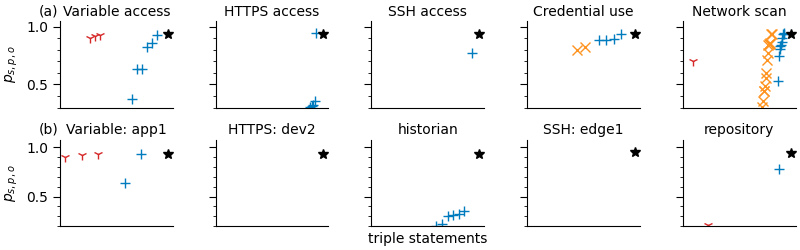

In [6]:
draw_plot_grid(RESCAL_model)

## Energy Results ##

The energy-based model using the RESCAL scoring function shows better results than RESCAL alone. However, the higher levels of suspicion are scored much too high, and the different levels of suspicion receive scores that are too similar (i.e., they are not adequately separated on the y-axis). The main improvement with this model is that in most cases, scores within a single suspicion level are tighter.

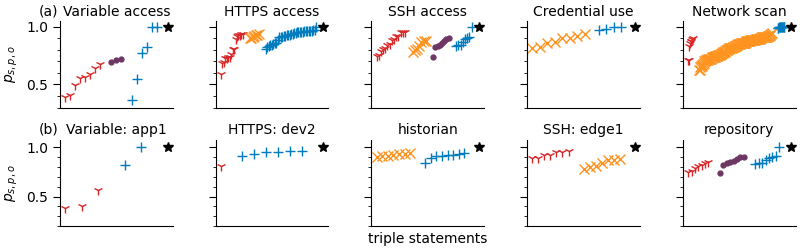

In [7]:
draw_plot_grid(energy_model)

## Energy Diag Results ##

The energy-based model using the DistMult scoring function shows improved results over the version using the RESCAL scoring function. Higher suspicion levels achieve much lower scores, so there is better spread over the y-axis across the different suspicion levels overall. Also, scores within the same suspicion level are still tighter in most cases than the RESCAL version of the energy-based model. However, in the overall test cases, there is still considerable overlap between scores of different levels of suspicion. This is at least partially mitigated by examining individual entities within the network, which show stronger results.

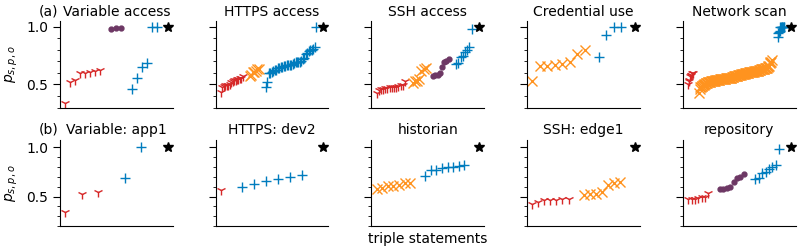

In [8]:
draw_plot_grid(energy_diag_model)